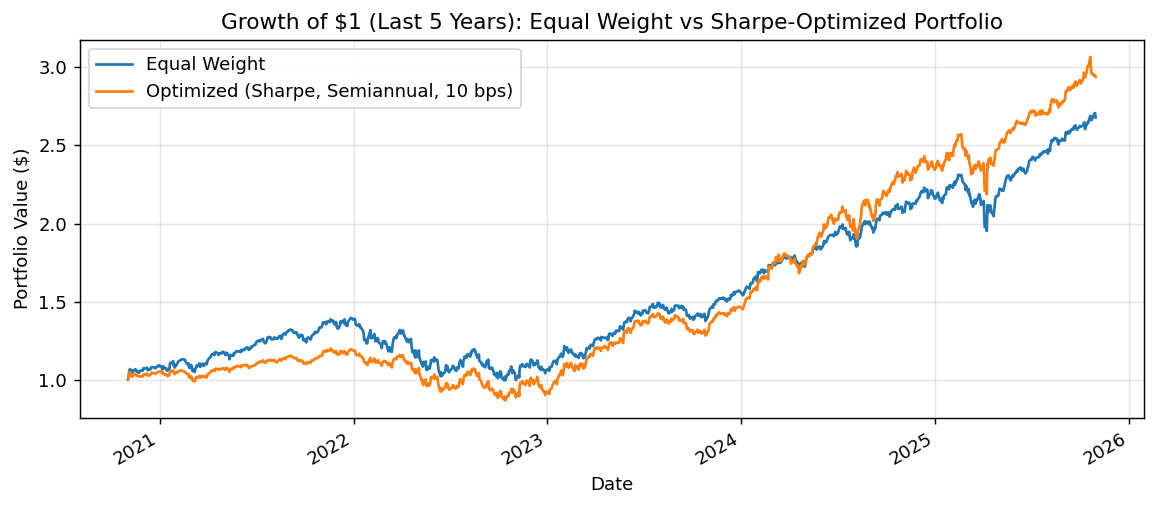

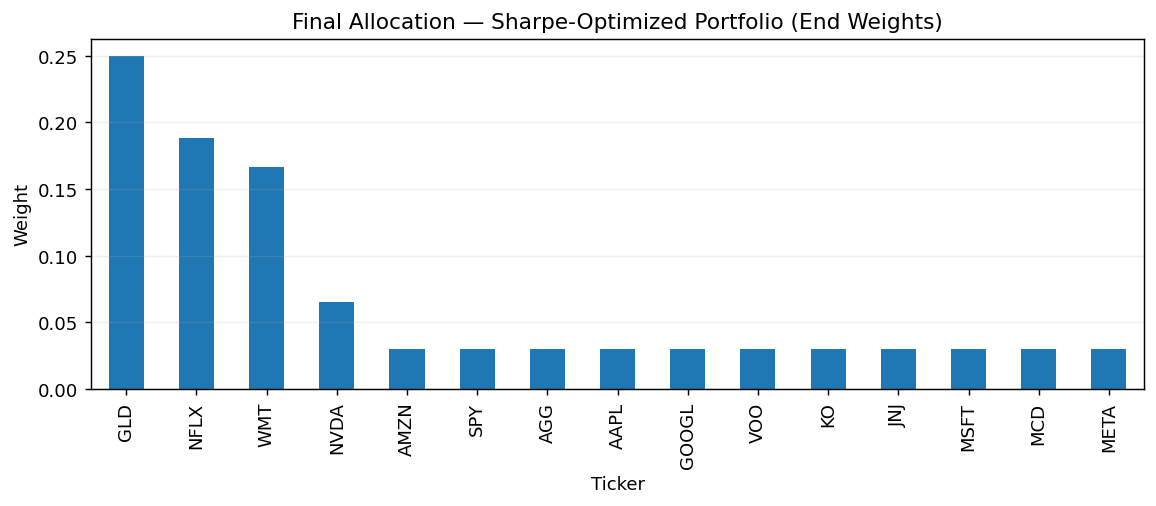


[Summary Metrics — Last 5 Years]
Equal Weight: {'Return': 0.21218422385279984, 'Volatility': 0.16944989008994935, 'Sharpe': 1.2521945203987195, 'Drawdown': -0.285098833056989}
Sharpe-Optimized (Semiannual, 10 bps): {'Return': 0.23177262011433028, 'Volatility': 0.1753701456632664, 'Sharpe': 1.3216195905964747, 'Drawdown': -0.2759228782937806}


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.rcParams["figure.dpi"] = 130


TICKERS = [
    "SPY","AAPL","MSFT","AMZN","GOOGL","KO","META","MCD","NFLX","AGG",
    "VOO","NVDA","GLD","JNJ","WMT"
]
FREQ = 252
MIN_W, MAX_W = 0.03, 0.25          # 3–25% caps
COST_BPS = 10.0                    # round-trip turnover cost
LOOKBACK_DAYS = 252*3              # 3y window for rolling optimization
STEP_DAYS = 126                    # ~semiannual
YEARS_PULL = 8                     # download 8y
PLOT_LAST_YEARS = 5                # show last 5y in growth plots

def get_prices(years=YEARS_PULL):
    start = (pd.Timestamp.today() - pd.DateOffset(years=years)).strftime("%Y-%m-%d")
    px = yf.download(TICKERS, start=start, auto_adjust=True, progress=False)["Close"]
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = px.columns.get_level_values(0)
    return px.dropna()

def pct_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return prices.pct_change().dropna()


def sharpe_ratio(w, mu, Sigma):
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w, np.dot(Sigma, w)))
    # To avoid division by zero
    if vol < 1e-8:
        return 0
    return ret / vol

def neg_sharpe(w, mu, Sigma):
    # Negative for minimizer
    return -sharpe_ratio(w, mu, Sigma)

def optimize_sharpe(mu, Sigma, min_w, max_w):
    n = len(mu)
    bounds = [(min_w, max_w)] * n
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    w0 = np.ones(n) / n  # Start from equal weight
    res = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=cons)
    if not res.success:
        print("Warning: Optimization failed:", res.message)
    return res.x

 
def semiannual_sharpe_backtest(prices: pd.DataFrame,
                        lookback_days=LOOKBACK_DAYS,
                        step_days=STEP_DAYS,
                        min_w=MIN_W,
                        max_w=MAX_W,
                        cost_bps=COST_BPS):
    r = pct_returns(prices)
    dates = r.index
    n = r.shape[1]
    ew = np.ones(n)/n

    out = pd.Series(index=dates, dtype=float)
    w_last = ew.copy()
    w_end  = ew.copy()

    t = lookback_days
    while t < len(dates):
        window = r.iloc[t-lookback_days:t]
        mu = window.mean().values
        Sigma = window.cov().values

        w_star = optimize_sharpe(mu, Sigma, min_w, max_w)

        t_next = min(t + step_days, len(dates))
        per = r.iloc[t:t_next]

        turnover = np.abs(w_star - w_last).sum()
        cost = (cost_bps/10000.0) * turnover
        rp = per @ w_star
        if len(rp) > 0:
            rp.iloc[0] = rp.iloc[0] - cost
        out.loc[per.index] = rp.values

        w_last = w_star
        w_end = w_star
        t = t_next

    return out.dropna(), w_end


def plot_growth(series_df: pd.DataFrame, title: str):
    (1+series_df).cumprod().plot(figsize=(9,4), title=title)
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True, alpha=.3)
    plt.tight_layout(); plt.show()

def plot_final_alloc(w, tickers, title):
    plt.figure(figsize=(9,4))
    pd.Series(w, index=tickers).sort_values(ascending=False).plot(kind="bar")
    plt.ylabel("Weight"); plt.title(title)
    plt.grid(True, axis='y', alpha=.2); plt.tight_layout(); plt.show()

def ann_metrics(r: pd.Series, freq=FREQ):
    ann_ret = r.mean()*freq
    ann_vol = r.std()*np.sqrt(freq)
    sharpe  = ann_ret/ann_vol if ann_vol>0 else np.nan
    eq = (1+r).cumprod()
    mdd = (eq/eq.cummax()-1).min()
    return {"Return": float(ann_ret), "Volatility": float(ann_vol),
            "Sharpe": float(sharpe), "Drawdown": float(mdd)}


if __name__ == "__main__":
    prices_all = get_prices(YEARS_PULL)
    rets_all   = pct_returns(prices_all)

   
    n = rets_all.shape[1]
    ew = np.ones(n)/n
    r_eq_all = (rets_all @ ew).rename("Equal Weight")

    
    cutoff = rets_all.index[-1] - pd.DateOffset(years=PLOT_LAST_YEARS)
    rets_5y = rets_all.loc[rets_all.index >= cutoff]
    r_eq_5y = r_eq_all.loc[rets_5y.index]

    
    r_roll_5y, w_end = semiannual_sharpe_backtest(prices_all,
                                                  lookback_days=LOOKBACK_DAYS,
                                                  step_days=STEP_DAYS,
                                                  min_w=MIN_W,
                                                  max_w=MAX_W,
                                                  cost_bps=COST_BPS)
    r_roll_5y = r_roll_5y.loc[r_roll_5y.index >= cutoff]
    r_eq_roll = r_eq_all.loc[r_roll_5y.index]

    
    plot_growth(pd.concat([r_eq_roll.rename("Equal Weight"),
                           r_roll_5y.rename(f"Optimized (Sharpe, Semiannual, {int(COST_BPS)} bps)")], axis=1),
                "Growth of $1 (Last 5 Years): Equal Weight vs Sharpe-Optimized Portfolio")

    
    plot_final_alloc(w_end, rets_all.columns, "Final Allocation — Sharpe-Optimized Portfolio (End Weights)")

   
    print("\n[Summary Metrics — Last 5 Years]")
    print("Equal Weight:", ann_metrics(r_eq_roll))
    print(f"Sharpe-Optimized (Semiannual, {int(COST_BPS)} bps):", ann_metrics(r_roll_5y))



   
   